<a href="https://colab.research.google.com/github/Bebin11/AI_Coursework/blob/main/Classification_Task_BRFSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Task - B.Sc. Computer Science ML Assignment
**Dataset:** Nutrition, Physical Activity, and Obesity - BRFSS (CDC)

**Target Variable:** `Data_Value_Alt` (converted to binary classification)

**Models:** Neural Network (MLP), Logistic Regression, Random Forest

**Environment:** Google Colab

## Cell 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

print('All libraries imported successfully!')

All libraries imported successfully!


## Cell 2: Load the Dataset from CDC API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load directly from the CDC Socrata Open Data API
df = pd.read_csv('/content/drive/MyDrive/Nutrition,_Physical_Activity,_and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System_20260125.csv')
print(f'Dataset loaded successfully!')
print(f'Shape: {df.shape}')
df.head()

Dataset loaded successfully!
Shape: (110880, 33)


,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$15,000 - $24,999",INC,INC1525
1,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$25,000 - $34,999",INC,INC2535
2,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$35,000 - $49,999",INC,INC3550
3,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$50,000 - $74,999",INC,INC5075
4,2011,2011,AL,Alabama,Behavioral Risk Factor Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,NaN,Value,...,"(32.840571122, -86.631860762)",OWS,OWS1,Q036,VALUE,1,Income,"$75,000 or greater",INC,INC75PLUS


## Cell 3: Target Variable Preparation

In [ ]:
# Drop rows where the target is missing
print(f'Shape before dropping missing target: {df.shape}')
df = df.dropna(subset=['Data_Value_Alt'])
print(f'Shape after dropping missing target: {df.shape}')

# Convert to binary: 1 if Data_Value_Alt > median, 0 otherwise
median_value = df['Data_Value_Alt'].median()
print(f'\nMedian of Data_Value_Alt: {median_value}')

df['Target'] = (df['Data_Value_Alt'] > median_value).astype(int)
print(f'\nTarget distribution:')
print(df['Target'].value_counts())

Shape before dropping missing target: (110880, 33)
Shape after dropping missing target: (97666, 33)

Median of Data_Value_Alt: 31.8

Target distribution:
Target
0    49237
1    48429
Name: count, dtype: int64


## Cell 4: EDA - Dataset Shape and Column Inspection

In [ ]:
print('=' * 60)
print('DATASET SHAPE AND COLUMN INSPECTION')
print('=' * 60)
print(f'\nShape: {df.shape}')
print(f'\nColumn names and data types:')
print(df.dtypes)
print(f'\nBasic Statistics:')
df.describe()

DATASET SHAPE AND COLUMN INSPECTION

Shape: (97666, 34)

Column names and data types:
YearStart                       int64
YearEnd                         int64
LocationAbbr                   object
LocationDesc                   object
Datasource                     object
Class                          object
Topic                          object
Question                       object
Data_Value_Unit                object
Data_Value_Type                object
Data_Value                    float64
Data_Value_Alt                float64
Data_Value_Footnote_Symbol     object
Data_Value_Footnote            object
Low_Confidence_Limit          float64
High_Confidence_Limit         float64
Sample_Size                    object
Total                          object
Age(years)                     object
Education                      object
Sex                            object
Income                         object
Race/Ethnicity                 object
GeoLocation                    object
Cl

,YearStart,YearEnd,Data_Value,Data_Value_Alt,Low_Confidence_Limit,High_Confidence_Limit,LocationID,Target
count,97666.000000,97666.000000,97666.000000,97666.000000,97666.000000,97666.000000,97666.000000,97666.000000
mean,2017.272562,2017.272562,31.800252,31.800252,27.395236,36.767070,30.766736,0.495863
std,3.924617,3.924617,10.343087,10.343087,10.130335,11.282278,17.414247,0.499985
min,2011.000000,2011.000000,0.900000,0.900000,0.300000,3.000000,1.000000,0.000000
25%,2014.000000,2014.000000,24.900000,24.900000,20.400000,29.200000,17.000000,0.000000
50%,2017.000000,2017.000000,31.800000,31.800000,27.300000,36.500000,30.000000,0.000000
75%,2021.000000,2021.000000,37.400000,37.400000,33.300000,42.800000,45.000000,1.000000
max,2024.000000,2024.000000,85.300000,85.300000,74.700000,92.400000,78.000000,1.000000


## Cell 5: EDA - Missing Value Counts Per Column

In [ ]:
print('=' * 60)
print('MISSING VALUE COUNTS PER COLUMN')
print('=' * 60)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

MISSING VALUE COUNTS PER COLUMN
                            Missing Count  Percentage (%)
Data_Value_Footnote_Symbol          97666      100.000000
Data_Value_Footnote                 97666      100.000000
Total                               93820       96.062089
Data_Value_Unit                     93505       95.739561
Sex                                 89974       92.124178
Education                           82282       84.248357
Race/Ethnicity                      76915       78.753097
Age(years)                          74590       76.372535
Income                              70749       72.439744
GeoLocation                          2013        2.061106


## Cell 6: EDA - Distribution Plot for Target Variable

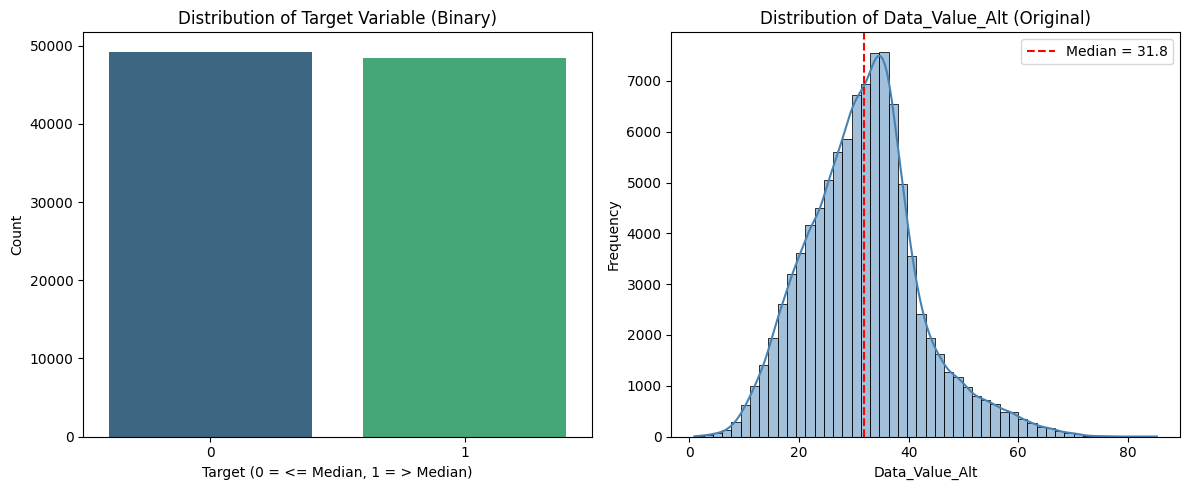

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot of target
sns.countplot(x='Target', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Target Variable (Binary)')
axes[0].set_xlabel('Target (0 = <= Median, 1 = > Median)')
axes[0].set_ylabel('Count')

# Original Data_Value_Alt distribution
sns.histplot(df['Data_Value_Alt'], bins=50, kde=True, ax=axes[1], color='steelblue')
axes[1].axvline(median_value, color='red', linestyle='--', label=f'Median = {median_value}')
axes[1].set_title('Distribution of Data_Value_Alt (Original)')
axes[1].set_xlabel('Data_Value_Alt')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## Cell 7: EDA - Distribution Plots for Key Numerical Features

Numerical features: ['YearStart', 'YearEnd', 'Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'LocationID']


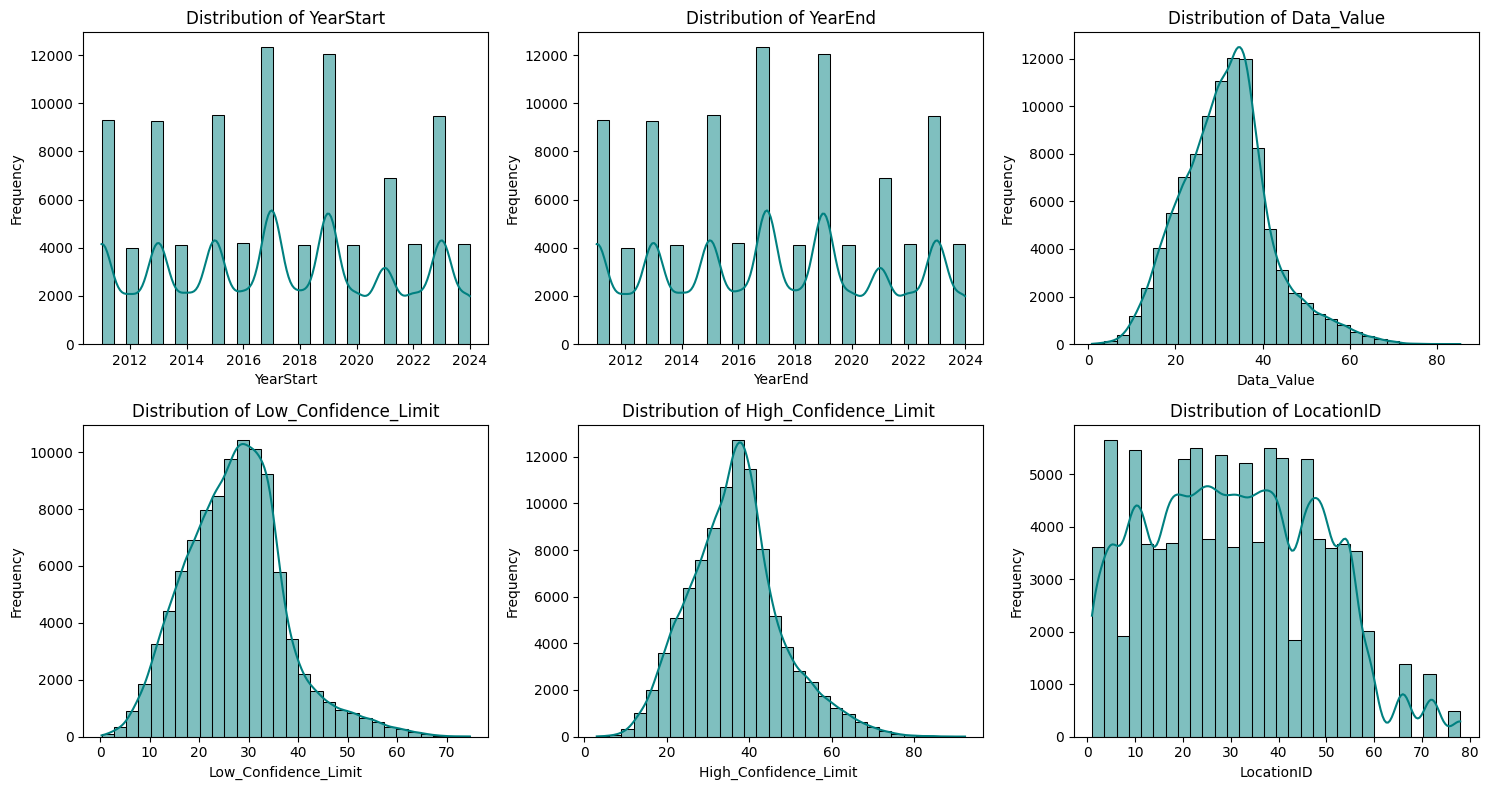

In [ ]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = ['Target', 'Data_Value_Alt']
num_features = [c for c in numerical_cols if c not in cols_to_exclude]

print(f'Numerical features: {num_features}')

n_cols_plot = 3
n_rows_plot = (len(num_features) + n_cols_plot - 1) // n_cols_plot

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(5 * n_cols_plot, 4 * n_rows_plot))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Cell 8: EDA - Correlation Matrix and Heatmap

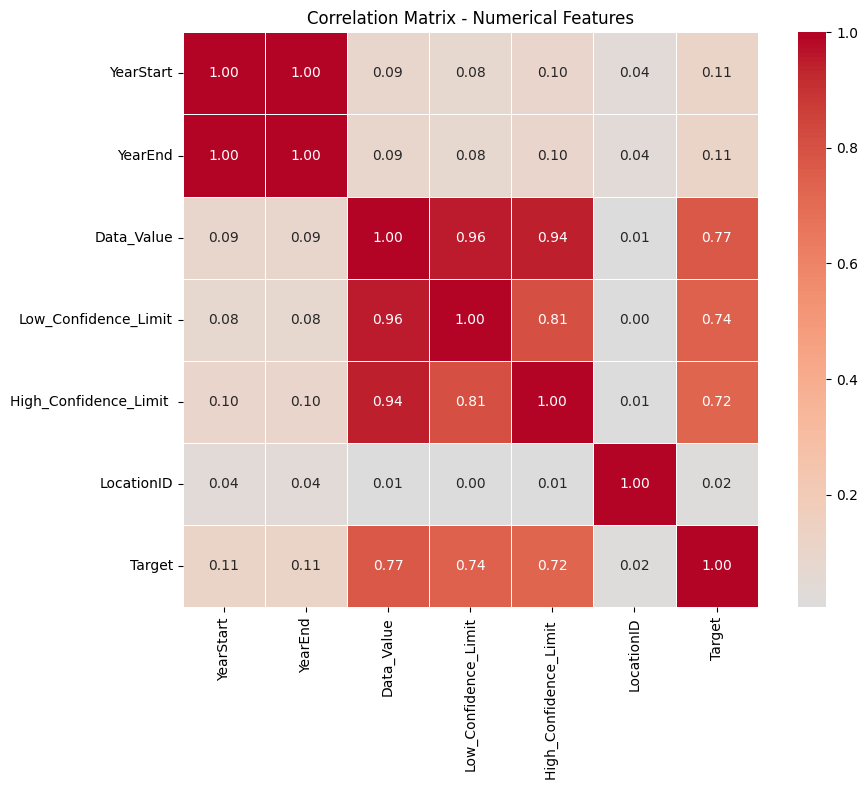

In [ ]:
corr_cols = num_features + ['Target']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

## Cell 9: Preprocessing - Drop Unnecessary Columns

In [ ]:
cols_to_drop = ['Data_Value_Alt', 'Data_Value', 'Data_Value_Unit',
                'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
                'LocationDesc', 'Datasource', 'Topic', 'TopicID', 'ClassID',
                'QuestionID', 'DataValueTypeID', 'Data_Value_Type',
                'StratificationCategoryId1', 'StratificationID1',
                'LocationID', 'GeoLocation',
                'Low_Confidence_Limit', 'High_Confidence_Limit',
                'Sample_Size']

cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df_model = df.drop(columns=cols_to_drop)

print(f'Shape after dropping unnecessary columns: {df_model.shape}')
print(f'\nRemaining columns: {list(df_model.columns)}')
print(f'\nData types:\n{df_model.dtypes}')

Shape after dropping unnecessary columns: (97666, 15)

Remaining columns: ['YearStart', 'YearEnd', 'LocationAbbr', 'Class', 'Question', 'High_Confidence_Limit ', 'Total', 'Age(years)', 'Education', 'Sex', 'Income', 'Race/Ethnicity', 'StratificationCategory1', 'Stratification1', 'Target']

Data types:
YearStart                    int64
YearEnd                      int64
LocationAbbr                object
Class                       object
Question                    object
High_Confidence_Limit      float64
Total                       object
Age(years)                  object
Education                   object
Sex                         object
Income                      object
Race/Ethnicity              object
StratificationCategory1     object
Stratification1             object
Target                       int64
dtype: object


## Cell 10: Preprocessing - Handle Missing Values

In [ ]:
# Numerical columns: fill with median
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Target']

for col in num_cols:
    median_val = df_model[col].median()
    df_model[col] = df_model[col].fillna(median_val)
    print(f"Filled missing values in '{col}' with median: {median_val}")

# Categorical columns: fill with mode
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    mode_val = df_model[col].mode()[0]
    df_model[col] = df_model[col].fillna(mode_val)
    print(f"Filled missing values in '{col}' with mode: {mode_val}")

print(f'\nRemaining missing values: {df_model.isnull().sum().sum()}')

Filled missing values in 'YearStart' with median: 2017.0
Filled missing values in 'YearEnd' with median: 2017.0
Filled missing values in 'High_Confidence_Limit ' with median: 36.5
Filled missing values in 'LocationAbbr' with mode: US
Filled missing values in 'Class' with mode: Physical Activity
Filled missing values in 'Question' with mode: Percent of adults who engage in no leisure-time physical activity
Filled missing values in 'Total' with mode: Total
Filled missing values in 'Age(years)' with mode: 18 - 24
Filled missing values in 'Education' with mode: College graduate
Filled missing values in 'Sex' with mode: Female
Filled missing values in 'Income' with mode: $15,000 - $24,999
Filled missing values in 'Race/Ethnicity' with mode: Non-Hispanic White
Filled missing values in 'StratificationCategory1' with mode: Income
Filled missing values in 'Stratification1' with mode: $15,000 - $24,999

Remaining missing values: 0


## Cell 11: Preprocessing - Encode Categorical Variables

In [ ]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"Label Encoded '{col}': {len(le.classes_)} unique classes")

print(f'\nFinal dataset shape: {df_model.shape}')
df_model.head()

Label Encoded 'LocationAbbr': 55 unique classes
Label Encoded 'Class': 3 unique classes
Label Encoded 'Question': 9 unique classes
Label Encoded 'Total': 1 unique classes
Label Encoded 'Age(years)': 6 unique classes
Label Encoded 'Education': 5 unique classes
Label Encoded 'Sex': 2 unique classes
Label Encoded 'Income': 7 unique classes
Label Encoded 'Race/Ethnicity': 8 unique classes
Label Encoded 'StratificationCategory1': 6 unique classes
Label Encoded 'Stratification1': 28 unique classes

Final dataset shape: (97666, 15)


,YearStart,YearEnd,LocationAbbr,Class,Question,High_Confidence_Limit,Total,Age(years),Education,Sex,Income,Race/Ethnicity,StratificationCategory1,Stratification1,Target
0,2011,2011,1,1,1,38.5,0,0,0,0,0,6,2,0,1
1,2011,2011,1,1,1,40.8,0,0,0,0,1,6,2,1,1
2,2011,2011,1,1,1,36.8,0,0,0,0,2,6,2,2,1
3,2011,2011,1,1,1,38.8,0,0,0,0,3,6,2,3,1
4,2011,2011,1,1,1,32.5,0,0,0,0,4,6,2,4,0


## Cell 12: Preprocessing - Scale Features and Train-Test Split

In [ ]:
# Separate features and target
X = df_model.drop(columns=['Target'])
y = df_model['Target']

feature_names = X.columns.tolist()
print(f'Number of features: {len(feature_names)}')
print(f'Features: {feature_names}')

# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_names, index=X.index)

# 80/20 Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTraining set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'\nTraining target distribution:\n{y_train.value_counts()}')
print(f'\nTest target distribution:\n{y_test.value_counts()}')

Number of features: 14
Features: ['YearStart', 'YearEnd', 'LocationAbbr', 'Class', 'Question', 'High_Confidence_Limit ', 'Total', 'Age(years)', 'Education', 'Sex', 'Income', 'Race/Ethnicity', 'StratificationCategory1', 'Stratification1']

Training set shape: (78132, 14)
Test set shape: (19534, 14)

Training target distribution:
Target
0    39389
1    38743
Name: count, dtype: int64

Test target distribution:
Target
0    9848
1    9686
Name: count, dtype: int64


## Cell 13: Helper Function - Manual Metric Computation
**Note:** This function does NOT use `accuracy_score`, `precision_score`, `recall_score`, or `f1_score` from sklearn.
All metrics are computed manually from TP, TN, FP, FN values.

In [ ]:
def compute_metrics_manual(y_true, y_pred):
    """
    Compute Accuracy, Precision, Recall, F1-score manually
    using confusion matrix values (TP, TN, FP, FN).
    Does NOT use sklearn's accuracy_score, precision_score, recall_score, f1_score.
    """
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    print(f'  TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}')

    # Manual calculations using mathematical formulas
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    }

print('Helper function defined successfully!')

Helper function defined successfully!


## Cell 14: Model 1 - Neural Network (MLPClassifier)

In [ ]:
print('=' * 60)
print('MODEL 1: NEURAL NETWORK (MLPClassifier)')
print('=' * 60)

# Define architecture explicitly: 3 hidden layers (128, 64, 32)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    learning_rate='adaptive'
)

# Train on training set
mlp.fit(X_train, y_train)
print('MLPClassifier trained successfully!')
print(f'Architecture: Input({X_train.shape[1]}) -> 128 -> 64 -> 32 -> Output(2)')
print(f'Number of iterations: {mlp.n_iter_}')

# Generate predictions on both training and test sets
y_train_pred_mlp = mlp.predict(X_train)
y_test_pred_mlp = mlp.predict(X_test)

# Evaluate
print('\n--- Training Set Metrics ---')
train_metrics_mlp = compute_metrics_manual(y_train, y_train_pred_mlp)
print(f"  Accuracy:  {train_metrics_mlp['Accuracy']}")
print(f"  Precision: {train_metrics_mlp['Precision']}")
print(f"  Recall:    {train_metrics_mlp['Recall']}")
print(f"  F1-Score:  {train_metrics_mlp['F1-Score']}")

print('\n--- Test Set Metrics ---')
test_metrics_mlp = compute_metrics_manual(y_test, y_test_pred_mlp)
print(f"  Accuracy:  {test_metrics_mlp['Accuracy']}")
print(f"  Precision: {test_metrics_mlp['Precision']}")
print(f"  Recall:    {test_metrics_mlp['Recall']}")
print(f"  F1-Score:  {test_metrics_mlp['F1-Score']}")

n_features_mlp = X_train.shape[1]

MODEL 1: NEURAL NETWORK (MLPClassifier)
MLPClassifier trained successfully!
Architecture: Input(14) -> 128 -> 64 -> 32 -> Output(2)
Number of iterations: 61

--- Training Set Metrics ---
  TP = 37179, TN = 37335, FP = 2054, FN = 1564
  Accuracy:  0.9537
  Precision: 0.9476
  Recall:    0.9596
  F1-Score:  0.9536

--- Test Set Metrics ---
  TP = 9265, TN = 9276, FP = 572, FN = 421
  Accuracy:  0.9492
  Precision: 0.9419
  Recall:    0.9565
  F1-Score:  0.9491


## Cell 15: Model 2 - Logistic Regression

In [ ]:
print('=' * 60)
print('MODEL 2: LOGISTIC REGRESSION')
print('=' * 60)

# Step 1: Train baseline model
print('\n--- Step 1: Baseline Model ---')
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train, y_train)
y_test_pred_lr_base = lr_baseline.predict(X_test)
baseline_metrics = compute_metrics_manual(y_test, y_test_pred_lr_base)
print(f"  Baseline Test Accuracy: {baseline_metrics['Accuracy']}")

# Step 2: Hyperparameter Tuning using GridSearchCV
print('\n--- Step 2: Hyperparameter Tuning (GridSearchCV) ---')
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_lr.fit(X_train, y_train)
print(f'  Best Parameters: {grid_lr.best_params_}')
print(f'  Best CV Score: {round(grid_lr.best_score_, 4)}')

# Step 3: Feature Selection using RFE
print('\n--- Step 3: Feature Selection (RFE) ---')
best_lr = grid_lr.best_estimator_
rfe_lr = RFE(estimator=best_lr, n_features_to_select=10, step=1)
rfe_lr.fit(X_train, y_train)

selected_features_lr = [f for f, s in zip(feature_names, rfe_lr.support_) if s]
print(f'  Selected {len(selected_features_lr)} features: {selected_features_lr}')

# Step 4: Retrain final model with selected features and best hyperparameters
print('\n--- Step 4: Retrain Final Model ---')
X_train_lr = X_train[selected_features_lr]
X_test_lr = X_test[selected_features_lr]

lr_final = LogisticRegression(
    **grid_lr.best_params_,
    random_state=42,
    max_iter=1000
)
lr_final.fit(X_train_lr, y_train)

# Generate predictions on both training and test sets
y_train_pred_lr = lr_final.predict(X_train_lr)
y_test_pred_lr = lr_final.predict(X_test_lr)

# Evaluate
print('\n--- Training Set Metrics ---')
train_metrics_lr = compute_metrics_manual(y_train, y_train_pred_lr)
print(f"  Accuracy:  {train_metrics_lr['Accuracy']}")
print(f"  Precision: {train_metrics_lr['Precision']}")
print(f"  Recall:    {train_metrics_lr['Recall']}")
print(f"  F1-Score:  {train_metrics_lr['F1-Score']}")

print('\n--- Test Set Metrics ---')
test_metrics_lr = compute_metrics_manual(y_test, y_test_pred_lr)
print(f"  Accuracy:  {test_metrics_lr['Accuracy']}")
print(f"  Precision: {test_metrics_lr['Precision']}")
print(f"  Recall:    {test_metrics_lr['Recall']}")
print(f"  F1-Score:  {test_metrics_lr['F1-Score']}")

n_features_lr = len(selected_features_lr)

MODEL 2: LOGISTIC REGRESSION

--- Step 1: Baseline Model ---
  TP = 9103, TN = 9117, FP = 731, FN = 583
  Baseline Test Accuracy: 0.9327

--- Step 2: Hyperparameter Tuning (GridSearchCV) ---
  Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV Score: 0.9309

--- Step 3: Feature Selection (RFE) ---
  Selected 10 features: ['LocationAbbr', 'Class', 'Question', 'High_Confidence_Limit ', 'Age(years)', 'Education', 'Sex', 'Income', 'Race/Ethnicity', 'StratificationCategory1']

--- Step 4: Retrain Final Model ---

--- Training Set Metrics ---
  TP = 36253, TN = 36467, FP = 2922, FN = 2490
  Accuracy:  0.9307
  Precision: 0.9254
  Recall:    0.9357
  F1-Score:  0.9305

--- Test Set Metrics ---
  TP = 9103, TN = 9116, FP = 732, FN = 583
  Accuracy:  0.9327
  Precision: 0.9256
  Recall:    0.9398
  F1-Score:  0.9326


## Cell 16: Model 3 - Random Forest Classifier

MODEL 3: RANDOM FOREST CLASSIFIER

--- Step 1: Baseline Model ---
  TP = 9280, TN = 9299, FP = 549, FN = 406
  Baseline Test Accuracy: 0.9511

--- Step 2: Hyperparameter Tuning (GridSearchCV) ---
  Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  Best CV Score: 0.9495

--- Step 3: Feature Selection (Embedded - Feature Importances) ---

Feature Importances:
                Feature  Importance
 High_Confidence_Limit     0.707462
               Question    0.109147
           LocationAbbr    0.040253
        Stratification1    0.030636
         Race/Ethnicity    0.022237
                  Class    0.019751
                YearEnd    0.016867
              YearStart    0.016765
StratificationCategory1    0.015796
                 Income    0.008289
             Age(years)    0.006656
              Education    0.005154
                    Sex    0.000987
                  Total    0.000000

  Selected 2 features (importance > mean=0.0

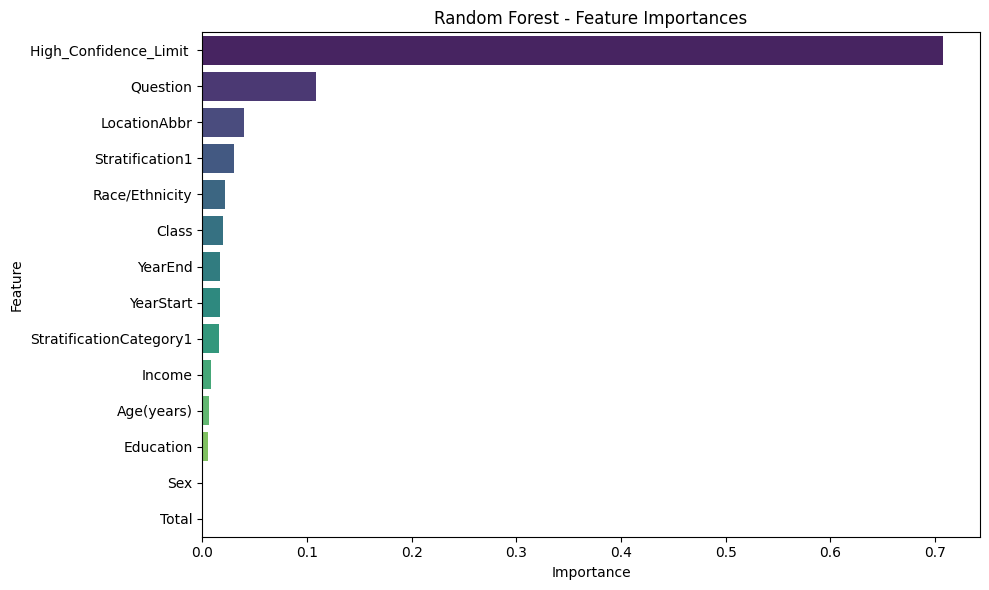


--- Step 4: Retrain Final Model ---

--- Training Set Metrics ---
  TP = 36937, TN = 34620, FP = 4769, FN = 1806
  Accuracy:  0.9158
  Precision: 0.8857
  Recall:    0.9534
  F1-Score:  0.9183

--- Test Set Metrics ---
  TP = 9200, TN = 8618, FP = 1230, FN = 486
  Accuracy:  0.9122
  Precision: 0.8821
  Recall:    0.9498
  F1-Score:  0.9147


In [ ]:
print('=' * 60)
print('MODEL 3: RANDOM FOREST CLASSIFIER')
print('=' * 60)

# Step 1: Train baseline model
print('\n--- Step 1: Baseline Model ---')
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
y_test_pred_rf_base = rf_baseline.predict(X_test)
baseline_metrics_rf = compute_metrics_manual(y_test, y_test_pred_rf_base)
print(f"  Baseline Test Accuracy: {baseline_metrics_rf['Accuracy']}")

# Step 2: Hyperparameter Tuning using GridSearchCV
print('\n--- Step 2: Hyperparameter Tuning (GridSearchCV) ---')
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_rf.fit(X_train, y_train)
print(f'  Best Parameters: {grid_rf.best_params_}')
print(f'  Best CV Score: {round(grid_rf.best_score_, 4)}')

# Step 3: Feature Selection using Embedded Method (Feature Importances)
print('\n--- Step 3: Feature Selection (Embedded - Feature Importances) ---')
best_rf = grid_rf.best_estimator_
importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print('\nFeature Importances:')
print(importance_df.to_string(index=False))

# Select features with importance above the mean
mean_importance = importances.mean()
selected_features_rf = importance_df[importance_df['Importance'] > mean_importance]['Feature'].tolist()
print(f'\n  Selected {len(selected_features_rf)} features (importance > mean={round(mean_importance, 4)}):')
print(f'  {selected_features_rf}')

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest - Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Step 4: Retrain final model with selected features and best hyperparameters
print('\n--- Step 4: Retrain Final Model ---')
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]

rf_final = RandomForestClassifier(
    **grid_rf.best_params_,
    random_state=42
)
rf_final.fit(X_train_rf, y_train)

# Generate predictions on both training and test sets
y_train_pred_rf = rf_final.predict(X_train_rf)
y_test_pred_rf = rf_final.predict(X_test_rf)

# Evaluate
print('\n--- Training Set Metrics ---')
train_metrics_rf = compute_metrics_manual(y_train, y_train_pred_rf)
print(f"  Accuracy:  {train_metrics_rf['Accuracy']}")
print(f"  Precision: {train_metrics_rf['Precision']}")
print(f"  Recall:    {train_metrics_rf['Recall']}")
print(f"  F1-Score:  {train_metrics_rf['F1-Score']}")

print('\n--- Test Set Metrics ---')
test_metrics_rf = compute_metrics_manual(y_test, y_test_pred_rf)
print(f"  Accuracy:  {test_metrics_rf['Accuracy']}")
print(f"  Precision: {test_metrics_rf['Precision']}")
print(f"  Recall:    {test_metrics_rf['Recall']}")
print(f"  F1-Score:  {test_metrics_rf['F1-Score']}")

n_features_rf = len(selected_features_rf)

## Cell 17: Final Output - Model Comparison Table

In [ ]:
print('=' * 70)
print('FINAL MODEL COMPARISON TABLE')
print('=' * 70)

comparison_data = {
    'Model': ['Neural Network (MLP)', 'Logistic Regression', 'Random Forest'],
    'Num Features': [n_features_mlp, n_features_lr, n_features_rf],
    'Train Accuracy': [train_metrics_mlp['Accuracy'], train_metrics_lr['Accuracy'], train_metrics_rf['Accuracy']],
    'Train Precision': [train_metrics_mlp['Precision'], train_metrics_lr['Precision'], train_metrics_rf['Precision']],
    'Train Recall': [train_metrics_mlp['Recall'], train_metrics_lr['Recall'], train_metrics_rf['Recall']],
    'Train F1-Score': [train_metrics_mlp['F1-Score'], train_metrics_lr['F1-Score'], train_metrics_rf['F1-Score']],
    'Test Accuracy': [test_metrics_mlp['Accuracy'], test_metrics_lr['Accuracy'], test_metrics_rf['Accuracy']],
    'Test Precision': [test_metrics_mlp['Precision'], test_metrics_lr['Precision'], test_metrics_rf['Precision']],
    'Test Recall': [test_metrics_mlp['Recall'], test_metrics_lr['Recall'], test_metrics_rf['Recall']],
    'Test F1-Score': [test_metrics_mlp['F1-Score'], test_metrics_lr['F1-Score'], test_metrics_rf['F1-Score']],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

FINAL MODEL COMPARISON TABLE
               Model  Num Features  Train Accuracy  Train Precision  Train Recall  Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score
Neural Network (MLP)            14          0.9537           0.9476        0.9596          0.9536         0.9492          0.9419       0.9565         0.9491
 Logistic Regression            10          0.9307           0.9254        0.9357          0.9305         0.9327          0.9256       0.9398         0.9326
       Random Forest             2          0.9158           0.8857        0.9534          0.9183         0.9122          0.8821       0.9498         0.9147


## Cell 18: Visualization - Final Comparison Bar Charts

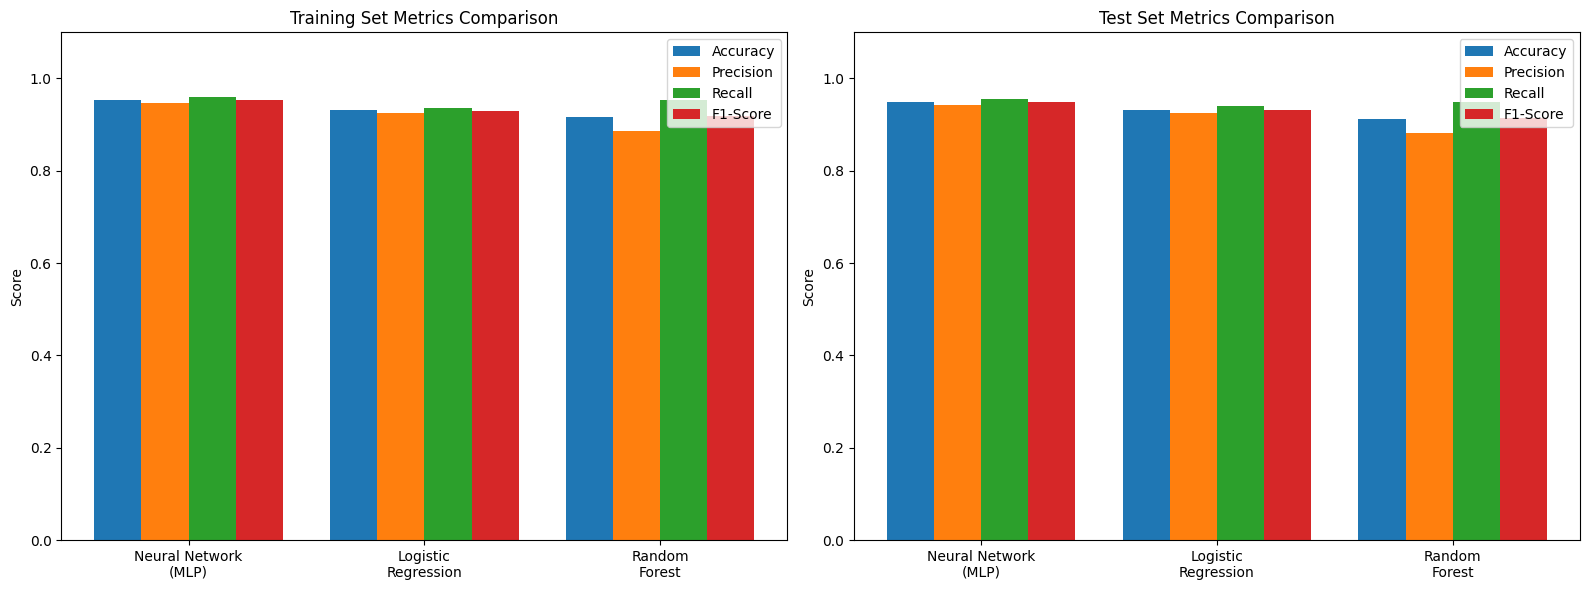


 Classification task completed successfully!


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = ['Neural Network\n(MLP)', 'Logistic\nRegression', 'Random\nForest']
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models))
width = 0.2

# Training Metrics
for i, metric in enumerate(metrics_list):
    values = [train_metrics_mlp[metric], train_metrics_lr[metric], train_metrics_rf[metric]]
    axes[0].bar(x + i * width, values, width, label=metric)
axes[0].set_title('Training Set Metrics Comparison')
axes[0].set_xticks(x + 1.5 * width)
axes[0].set_xticklabels(models)
axes[0].set_ylim(0, 1.1)
axes[0].legend()
axes[0].set_ylabel('Score')

# Test Metrics
for i, metric in enumerate(metrics_list):
    values = [test_metrics_mlp[metric], test_metrics_lr[metric], test_metrics_rf[metric]]
    axes[1].bar(x + i * width, values, width, label=metric)
axes[1].set_title('Test Set Metrics Comparison')
axes[1].set_xticks(x + 1.5 * width)
axes[1].set_xticklabels(models)
axes[1].set_ylim(0, 1.1)
axes[1].legend()
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

print('\n Classification task completed successfully!')